In [1]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [109]:
import tensorflow as tf
import pandas as pd
import numpy as np
import tensorflow.keras as tfk
import tensorflow.keras.layers as tfkl
import random
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import preprocess_input
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

In [3]:
# Random seed for reproducibility
seed = 10

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

In [ ]:
# os.chdir('/')
# %cd 'gdrive/MyDrive/Colab Notebooks/AN2&DL competition/dataset'

In [ ]:
# !unzip dataset.zip

In [4]:
os.chdir('/')
!ls

bin	 datalab  gdrive  lib32  mnt   python-apt  sbin  tensorflow-1.15.2  usr
boot	 dev	  home	  lib64  opt   root	   srv	 tmp		    var
content  etc	  lib	  media  proc  run	   sys	 tools


In [5]:
dataset_dir = r'gdrive/MyDrive/Colab Notebooks/AN2&DL competition/dataset/dataset'

training_dir = os.path.join(dataset_dir,'train')
test_dir     = os.path.join(dataset_dir,'test')
val_dir      = os.path.join(dataset_dir,'val')

# train_gen = train_data_gen.flow_from_directory(directory=training_dir,
#                                                color_mode='rgb',
#                                                classes=None,
#                                                batch_size=8,
#                                                shuffle=True,
#                                                seed=seed)

# test_gen  = test_data_gen.flow_from_directory(directory=test_dir,
#                                                color_mode='rgb',
#                                                classes=None,
#                                                batch_size=8,
#                                                shuffle=True,
#                                                seed=seed)

# val_gen = val_data_gen.flow_from_directory(directory=val_dir,
#                                                color_mode='rgb',
#                                                classes=None,
#                                                batch_size=8,
#                                                shuffle=True,
#                                                seed=seed)

In [6]:
os.chdir('/')
!ls

bin	 datalab  gdrive  lib32  mnt   python-apt  sbin  tensorflow-1.15.2  usr
boot	 dev	  home	  lib64  opt   root	   srv	 tmp		    var
content  etc	  lib	  media  proc  run	   sys	 tools


In [29]:
# Creating an instance of ImageDataGenerator without Data Augmentation
noaug_train_data_gen = ImageDataGenerator(preprocessing_function=tfk.applications.resnet50.preprocess_input)
valid_data_gen       = ImageDataGenerator(preprocessing_function=tfk.applications.resnet50.preprocess_input)
test_data_gen        = ImageDataGenerator(preprocessing_function=tfk.applications.resnet50.preprocess_input)

noaug_train_gen = noaug_train_data_gen.flow_from_directory(directory=training_dir,
                                                           target_size=(256,256),
                                                           color_mode='rgb',
                                                           classes=None,
                                                           class_mode='categorical',
                                                           batch_size=30,
                                                           shuffle=True,
                                                           seed=seed)

valid_gen = valid_data_gen.flow_from_directory(directory=val_dir,
                                               target_size=(256,256),
                                               color_mode='rgb',
                                               classes=None,
                                               class_mode='categorical',
                                               batch_size=30,
                                               shuffle=False, # no need to shuffle validation set
                                               seed=seed)

test_gen = test_data_gen.flow_from_directory(directory=test_dir,
                                             target_size=(256,256),
                                             color_mode='rgb',
                                             classes=None,
                                             class_mode='categorical',
                                             batch_size=30,
                                             shuffle=False, # no need to shuffle test set
                                             seed=seed)

Found 14176 images belonging to 14 classes.
Found 1765 images belonging to 14 classes.
Found 1787 images belonging to 14 classes.


In [28]:
# supernet = tfk.applications.VGG16(
#     include_top=False,
#     weights="imagenet",
#     input_shape=(256,256,3)
# )

supernet = tfk.applications.ResNet50(
    include_top=False,
    weights="imagenet",
    input_shape=(256,256,3),
)

94781440/94765736 [==============================] - 1s 0us/step


In [30]:
# Use the supernet as feature extractor
supernet.trainable = False

inputs = tfk.Input(shape=(256,256,3))
# x = tfkl.Resizing(64, 64, interpolation="bicubic")(inputs)
x = supernet(inputs)
x = tfkl.GlobalAveragePooling2D(name="gl_avg_pool")(x)
x = tfkl.Flatten(name='Flattening')(x)
x = tfkl.Dropout(0.3, seed=seed)(x)
x = tfkl.Dense(
    256, 
    activation='relu',
    kernel_initializer = tfk.initializers.GlorotUniform(seed))(x)
x = tfkl.Dropout(0.3, seed=seed)(x)
x = tfkl.Dense(
    256, 
    activation='relu',
    kernel_initializer = tfk.initializers.GlorotUniform(seed))(x)
x = tfkl.Dropout(0.3, seed=seed)(x)
x = tfkl.Dense(
    256, 
    activation='relu',
    kernel_initializer = tfk.initializers.GlorotUniform(seed))(x)
x = tfkl.Dropout(0.3, seed=seed)(x)
x = tfkl.Dense(
    256, 
    activation='relu',
    kernel_initializer = tfk.initializers.GlorotUniform(seed))(x)
x = tfkl.Dropout(0.3, seed=seed)(x)
outputs = tfkl.Dense(
    14, 
    activation='softmax',
    kernel_initializer = tfk.initializers.GlorotUniform(seed))(x)


# Connect input and output through the Model class
tl_model = tfk.Model(inputs=inputs, outputs=outputs, name='model')

# # Freeze first N layers, e.g., until 14th
# for i, layer in enumerate(tl_model.get_layer('vgg16').layers[:14]):
#   layer.trainable=False
# for i, layer in enumerate(tl_model.get_layer('vgg16').layers):
#    print(i, layer.name, layer.trainable)

# Compile the model
tl_model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics='accuracy')

In [31]:
# Train the model
os.chdir('/')
tl_history = tl_model.fit(
    x = noaug_train_gen,
    epochs = 150,
    validation_data = valid_gen,
    callbacks = [tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=10, restore_best_weights=True)]
).history


Epoch 1/150
473/473 [==============================] - 203s 290ms/step - loss: 0.7245 - accuracy: 0.7781 - val_loss: 0.1085 - val_accuracy: 0.9626
Epoch 2/150
473/473 [==============================] - 134s 282ms/step - loss: 0.2347 - accuracy: 0.9345 - val_loss: 0.0792 - val_accuracy: 0.9722
Epoch 3/150
473/473 [==============================] - 134s 283ms/step - loss: 0.1672 - accuracy: 0.9515 - val_loss: 0.0733 - val_accuracy: 0.9807
Epoch 4/150
473/473 [==============================] - 134s 282ms/step - loss: 0.1442 - accuracy: 0.9602 - val_loss: 0.0647 - val_accuracy: 0.9847
Epoch 5/150
473/473 [==============================] - 134s 282ms/step - loss: 0.1205 - accuracy: 0.9681 - val_loss: 0.0510 - val_accuracy: 0.9864
Epoch 6/150
473/473 [==============================] - 134s 284ms/step - loss: 0.1152 - accuracy: 0.9699 - val_loss: 0.0511 - val_accuracy: 0.9853
Epoch 7/150
473/473 [==============================] - 134s 284ms/step - loss: 0.0995 - accuracy: 0.9738 - val_loss: 0

In [34]:
import os
os.chdir('/')
os.chdir('gdrive/MyDrive/Colab Notebooks/AN2&DL competition')
tl_model.save('ft_model_without_data_aug')

INFO:tensorflow:Assets written to: ft_model_without_data_aug/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


In [ ]:
# Predict the test set with the CNN
os.chdir('/')
predictions = tl_model.predict(test_gen)
predictions.shape

In [73]:
one_hot_preds = tfk.utils.to_categorical(np.argmax(predictions, axis=-1), num_classes=14)
len(one_hot_preds)

1787

In [103]:
y_test = np.array([])

for i in range(len(test_gen)):
  for j in range(len(test_gen[i][1])):
    y_test = np.append(y_test, np.argmax(test_gen[i][1][j]))

In [105]:
y_test

array([ 0.,  0.,  0., ..., 13., 13., 13.])

Accuracy: 0.9933
Precision: 0.9934
Recall: 0.9933
F1: 0.9933


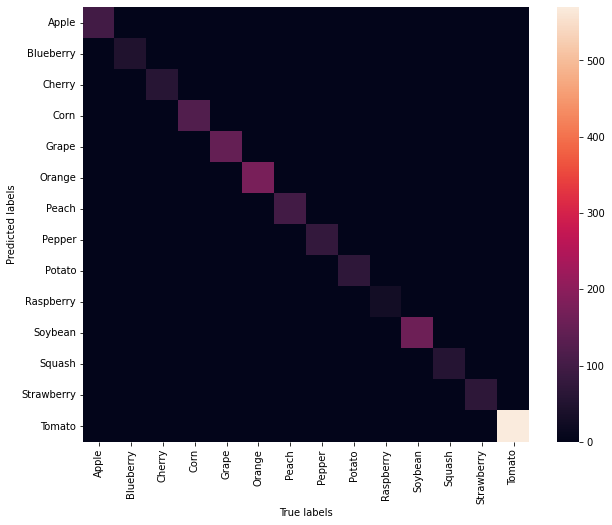

In [120]:
# Compute the confusion matrix
cm = confusion_matrix(y_test, np.argmax(predictions, axis=-1))

labels = {
    0:'Apple',     
    1:'Blueberry', 
    2:'Cherry',    
    3:'Corn',      
    4:'Grape',     
    5:'Orange',    
    6:'Peach',     
    7:'Pepper',    
    8:'Potato',    
    9:'Raspberry', 
    10:'Soybean',   
    11:'Squash',     
    12:'Strawberry',
    13:'Tomato'
}

# Compute the classification metrics
accuracy = accuracy_score(y_test, np.argmax(predictions, axis=-1))
precision = precision_score(y_test, np.argmax(predictions, axis=-1), average='weighted')
recall = recall_score(y_test, np.argmax(predictions, axis=-1), average='weighted')
f1 = f1_score(y_test, np.argmax(predictions, axis=-1), average='weighted')
print('Accuracy:',accuracy.round(4))
print('Precision:',precision.round(4))
print('Recall:',recall.round(4))
print('F1:',f1.round(4))

# Plot the confusion matrix
plt.figure(figsize=(10,8))
sns.heatmap(cm.T, xticklabels=list(labels.values()), yticklabels=list(labels.values()))
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()

In [ ]:
# Set all layers to True
ft_model.get_layer('vgg16').trainable = True
for i, layer in enumerate(ft_model.get_layer('vgg16').layers):
   print(i, layer.name, layer.trainable)

In [ ]:
# Freeze first N layers, e.g., until 14th
for i, layer in enumerate(ft_model.get_layer('vgg16').layers[:14]):
  layer.trainable=False
for i, layer in enumerate(ft_model.get_layer('vgg16').layers):
   print(i, layer.name, layer.trainable)

In [ ]:
# Compile the model
ft_model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(1e-4), metrics='accuracy')

In [ ]:
# Predict the test set with the CNN
predictions = ft_model.predict(X_test)
predictions.shape

# Compute the confusion matrix
cm = confusion_matrix(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1))

# Compute the classification metrics
accuracy = accuracy_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1))
precision = precision_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
recall = recall_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
f1 = f1_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
print('Accuracy:',accuracy.round(4))
print('Precision:',precision.round(4))
print('Recall:',recall.round(4))
print('F1:',f1.round(4))

# Plot the confusion matrix
plt.figure(figsize=(10,8))
sns.heatmap(cm.T, xticklabels=list(labels.values()), yticklabels=list(labels.values()))
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()